# Text Bounding Box with Tesseract

Tessaract OCR engine offers us several possibilities to OCR images. In this example, we explore the text localization, this region is delimited by a bounding box, inside this region, we extract the text. The template for this example is inspired on the [PyImageSearch](https://www.pyimagesearch.com/2020/05/25/tesseract-ocr-text-localization-and-detection/).

We explore two images to try to extract the bounding boxes and text. The first image comes from the example proposed by PyImageSearch. The second image comes from a question posted on [StackOverFlow](https://stackoverflow.com/questions/70007353/difficulty-detecting-digits-with-tesseract). We follow my [answer](https://stackoverflow.com/questions/70007353/difficulty-detecting-digits-with-tesseract/70020559#70020559) to OCR the text.

Tessaract uses deep learning to find text in images.

## Importing libraries

In [1]:
from pytesseract import Output
from imutils import paths
import pytesseract as tsr
import imutils
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

## Loading the images

In [2]:
dataset = 'dataset'
pathImages = list(paths.list_images(dataset))

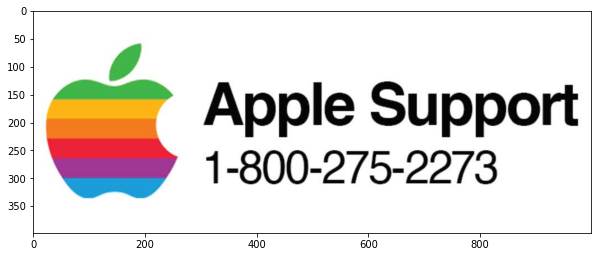

In [3]:
plt.figure(figsize=(10,10))
img = cv.imread(pathImages[1])
rgb = cv.cvtColor(img, cv.COLOR_BGR2RGBA)#converting to RGB order
plt.imshow(rgb)

## OCR'ing the image

We consider the function `tsr.image_to_data()`. The results are stored in a dictionary.

In [4]:
results = tsr.image_to_data(rgb, output_type=Output.DICT)#OCR'ing the image

In [5]:
results #look up the dictionary

{'level': [1, 2, 3, 4, 5, 4, 5, 5, 4, 5, 2, 3, 4, 5],
 'page_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'block_num': [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2],
 'par_num': [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
 'line_num': [0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 0, 0, 1, 1],
 'word_num': [0, 0, 0, 0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 1],
 'left': [0, 137, 137, 137, 137, 306, 306, 605, 310, 310, 22, 22, 22, 22],
 'top': [0, 60, 60, 60, 60, 127, 129, 127, 250, 250, 60, 60, 60, 60],
 'width': [1000,
  840,
  840,
  57,
  57,
  671,
  270,
  372,
  522,
  522,
  214,
  214,
  214,
  214],
 'height': [398, 251, 251, 67, 67, 100, 98, 100, 61, 61, 280, 280, 280, 280],
 'conf': ['-1',
  '-1',
  '-1',
  '-1',
  37,
  '-1',
  92,
  91,
  '-1',
  92,
  '-1',
  '-1',
  '-1',
  95],
 'text': ['',
  '',
  '',
  '',
  'g',
  '',
  'Apple',
  'Support',
  '',
  '1-800-275-2273',
  '',
  '',
  '',
  '']}

**Loop over the results to extract the bounding box coordinates**

Once we OCR'ed the image, we loop over the results dictionary. 

- Extract bounding box coordinates
- Extract the text
- Extract the confidence and select the detection according the confidence
- Clean and print out the text and bounding boxes.

Confidence: 92
Text: Apple

Confidence: 91
Text: Support

Confidence: 92
Text: 1-800-275-2273

Confidence: 95
Text: 



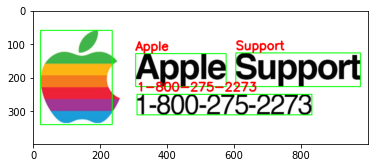

In [6]:
for i in range(0, len(results["text"])):
    
    #bounding box coordinates
    x = results['left'][i]
    y = results['top'][i]
    w = results['width'][i]
    h = results['height'][i]
    
    #Extract the text
    text = results["text"][i]
    conf = int(results["conf"][i])# Extracting the confidence
    
    #filtering the confidence
    if conf > 50:
        print("Confidence: {}".format(conf))
        print("Text: {}".format(text))
        print("")
        
        text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
        cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv.putText(img, text, (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

## Text bounding box with complex image

The above image can be considered as a “toy image”. It's very simple, with a cleaned background, to be OCR'ed. Recently, I found on StackOverFlow a question where someone demands help to OCR the follow image. The person wanted as result the bound box around the number. To do it, some image pre-processing techniques are required. After the image clean up, we apply the function `cv.tsr.image_to_data()`.

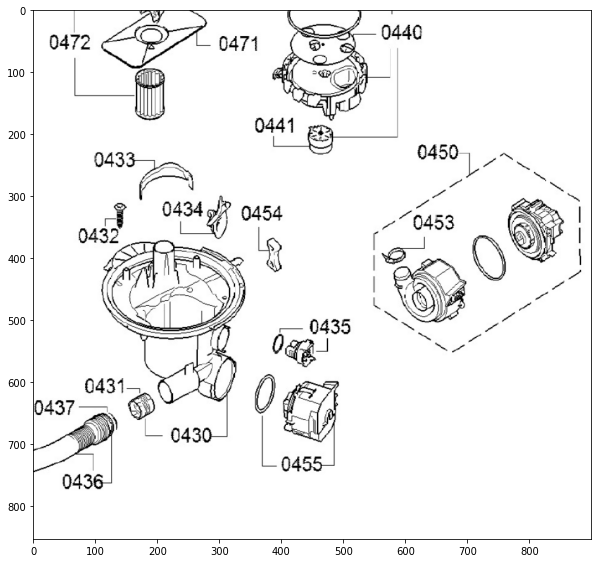

In [7]:
# loading and resizing image
img = cv.imread(pathImages[0])
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img = imutils.resize(img, width=900)
plt.figure(figsize=(10,10))
plt.imshow(img)

To pre-process the image we follow some steps

- convert your image into the gray scale
- apply image threshold using Otsu method and inverse operation
- apply distance transform
- apply morphological operation to clean up small points in your image
- apply dilate operation to enlarge your numbers
- find contours and filter them according the width and height of each contours
- create a list of hull objects to each contour
- draw the hull objects
- using dilate operation in your mask
- bitwise operation to retrieval the the segmented areas

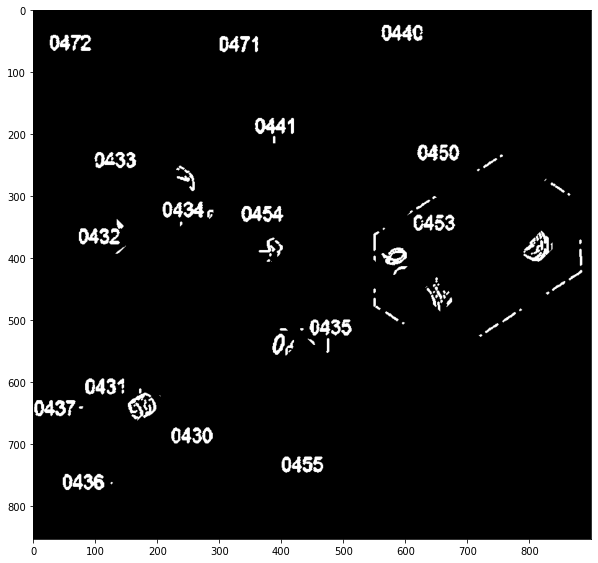

In [8]:
#gray scale
gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

# thresholding with Otsu method and inverse operation
thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV | 
cv.THRESH_OTSU)[1]

#distrance transform
dist = cv.distanceTransform(thresh, cv.DIST_L2, 5)
dist = cv.normalize(dist, dist, 0, 1.0, cv.NORM_MINMAX)
dist = (dist*255).astype('uint8')
dist = cv.threshold(dist, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]

# Morphological operation kernel (2,2) and OPEN method
kernel = cv.getStructuringElement(cv.MORPH_CROSS, (2,2))
opening = cv.morphologyEx(dist, cv.MORPH_OPEN, kernel)

#dilate operation to enlarge the numbers
kernel = cv.getStructuringElement(cv.MORPH_CROSS, (3,3))
dilation = cv.dilate(opening, kernel, iterations = 1)

#finding and grabbing the contours
cnts = cv.findContours(dilation.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

#filtering the contours
nums = []
output2 = img.copy()
for c in cnts:
    (x, y, w, h) = cv.boundingRect(c)

    if w >= 5 and w < 75 and h > 15 and h <= 35:
        nums.append(c)

# making a list with the hull points
hull = []
# calculate points for each contour
for i in range(len(nums)):
    # creating convex hull object for each contour
    hull.append(cv.convexHull(nums[i], False))

# create an empty black image
mask = np.zeros(dilation.shape[:2], dtype='uint8')

# draw contours and hull points
for i in range(len(nums)):
    color = (255, 0, 0) # blue - color for convex hull
    # draw ith convex hull object
    cv.drawContours(mask, hull, i, color, 1, 8)

#dilating the mask to have a proper image for bitwise
mask = cv.dilate(mask, kernel, iterations = 15)

#bitwise operation
final = cv.bitwise_and(dilation, dilation, mask=mask)
plt.figure(figsize=(10,10))
plt.imshow(cv.cvtColor(final, cv.COLOR_BGR2RGB))

As we can see, after the image pre-processing, our output image is not so cleaned. It can implicate in worse results then expected. Let's see the OCR.

We consider the page segmentation `--psm 12`, it considers the image as a sparse text. In addition, we create a white list to consider just numbers. At this moment, we consider all detections without confidence filtering.

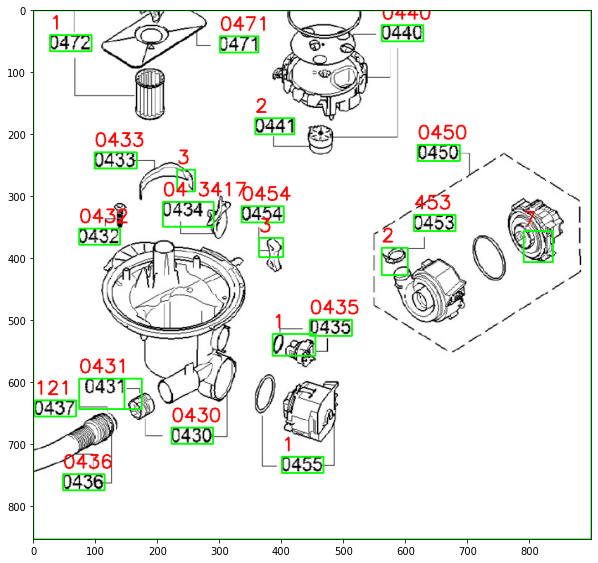

In [9]:
config = '--psm 12 -c tessedit_char_whitelist=0123456789' #page segmentation mode and white lists
#OCR'ing the image
results = tsr.image_to_data(final, config = config, output_type=Output.DICT)
plt.figure(figsize=(10,10))

img1 = img.copy()
for i in range(0, len(results["text"])):
    
    #bounding box coordinates
    x = results['left'][i]
    y = results['top'][i]
    w = results['width'][i]
    h = results['height'][i]
    
    #Extract the text
    text = results["text"][i]
    conf = int(results["conf"][i])# Extracting the confidence
    
    #filtering the confidence
    text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
    cv.rectangle(img1, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv.putText(img1, text, (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 1., (0, 0, 255), 2)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))

As seen in the image, Tesseract detected bounding box for all numbers. The problem is the accuracy of the detected text. The reason for these results are the image that are noised to returns an accurate result. If we filter the confidence for each bounding box, considering just high confidence, the printed out results will be different. Let’s see.

Confidence: 73
Text: 0440

Confidence: 92
Text: 0471

Confidence: 77
Text: 0433

Confidence: 96
Text: 0450

Confidence: 83
Text: 0454

Confidence: 96
Text: 0432

Confidence: 91
Text: 2

Confidence: 68
Text: 0435

Confidence: 54
Text:  0431

Confidence: 86
Text: 0430

Confidence: 78
Text: 0436



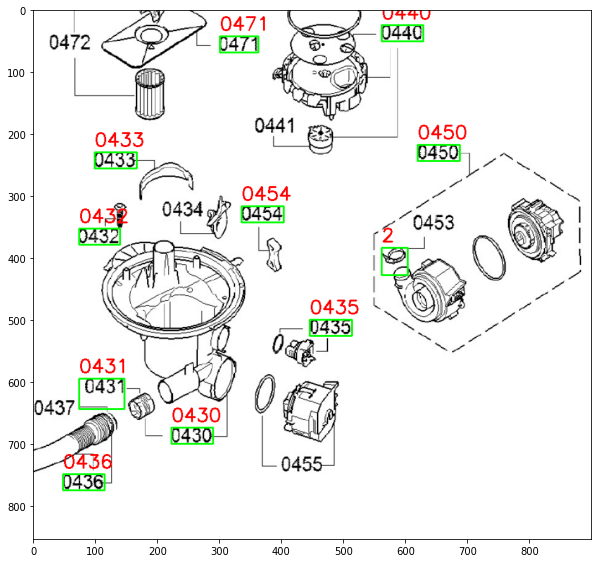

In [10]:
config = '--psm 12 -c tessedit_char_whitelist=0123456789' #page segmentation mode and white lists
#OCR'ing the image
results = tsr.image_to_data(final, config = config, output_type=Output.DICT)
plt.figure(figsize=(10,10))

for i in range(0, len(results["text"])):
    
    #bounding box coordinates
    x = results['left'][i]
    y = results['top'][i]
    w = results['width'][i]
    h = results['height'][i]
    
    #Extract the text
    text = results["text"][i]
    conf = int(results["conf"][i])# Extracting the confidence
    
    #filtering the confidence
    if conf > 50:
        print("Confidence: {}".format(conf))
        print("Text: {}".format(text))
        print("")
        
        text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
        cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv.putText(img, text, (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 1., (0, 0, 255), 2)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

## Conclusion

Given a perfect image, with a cleaned background, Tessaract can localize text and OCR it. The first image is a perfect example of how the model works. The second image requires a strong image pre-process, even if the manipulations, we did not reach a perfect output, but Tessaract was efficient, returning around $70\%$ of good results. To obtain a better result, we must think about noise pre-processing, using machine learning algorithms.